Bulunan bileşen sayısı (arka plan hariç): 5


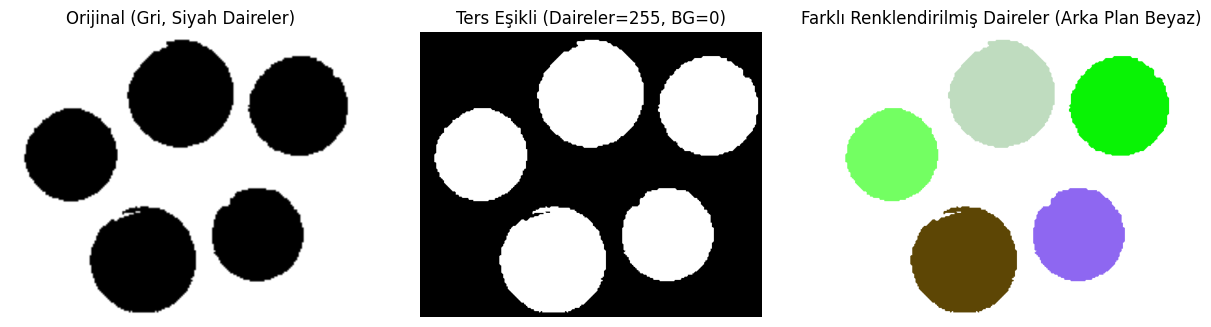

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

def connected_components_labeling(binary_img, connectivity=8):
    """
    binary_img : 0 veya 255 değerli ikili resim (foreground=255, background=0).
    connectivity: 4 veya 8. Bileşenleri hangi komşulukla birleştireceğiz.
    return: 
        labels (2D np array, int32) 
        n_labels (int) (bileşen sayısı)
    """
    h, w = binary_img.shape
    labels = np.zeros((h, w), dtype=np.int32)
    
    # Komşuluk seti
    if connectivity == 8:
        directions = [(-1, -1), (-1, 0), (-1, 1),
                      ( 0, -1),          ( 0, 1),
                      ( 1, -1), ( 1, 0), ( 1, 1)]
    else:  # 4-komşuluk
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    current_label = 0

    for y in range(h):
        for x in range(w):
            # Foreground piksel (255) ve daha önce etiketlenmemişse
            if binary_img[y, x] == 255 and labels[y, x] == 0:
                current_label += 1
                labels[y, x] = current_label
                # BFS veya DFS ile aynı bileşendeki diğer pikselleri de bul
                queue = deque()
                queue.append((y, x))

                while queue:
                    cy, cx = queue.popleft()  # BFS
                    for dy, dx in directions:
                        ny, nx = cy + dy, cx + dx
                        if 0 <= ny < h and 0 <= nx < w:
                            if binary_img[ny, nx] == 255 and labels[ny, nx] == 0:
                                labels[ny, nx] = current_label
                                queue.append((ny, nx))

    return labels, current_label


def labels_to_color(labels, n_labels, bg_color=(255, 255, 255)):
    """
    labels: 2D array, 0=arka plan, 1..n_labels=nesneler.
    n_labels: etiket sayısı
    bg_color: arka plan pikselleri için verilecek renk (burada beyaz).
    """
    h, w = labels.shape
    color_img = np.zeros((h, w, 3), dtype=np.uint8)

    # Tüm pikselleri önce arka plan rengine boyuyoruz (beyaz).
    color_img[:] = bg_color

    rng = np.random.default_rng()
    # Her label (1..n_labels) için rastgele (B,G,R) rengi oluştur
    random_colors = rng.integers(0, 256, size=(n_labels+1, 3), dtype=np.uint8)
    # Label=0 --> arka plan, mecburen bg_color olsun
    random_colors[0] = bg_color

    for y in range(h):
        for x in range(w):
            lbl = labels[y, x]
            if lbl != 0:  # arka plan pikseline dokunma
                color_img[y, x] = random_colors[lbl]

    return color_img

# Ana Kod
image = cv2.imread('../datasets/connected_comps.png', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError("Görüntü açılamadı!")

# 1) Ters eşikleme: 
#    Çünkü orijinalde daireler siyah(0), arka plan beyaz(255)
#    Biz "daireleri 255" yapmak istiyoruz:
_, binary_inv = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
# Artık binary_inv'de daireler (foreground) 255, arka plan 0 olmalı.

# 2) Bağlı bileşen tespiti (manuel)
labels, n_labels = connected_components_labeling(binary_inv, connectivity=8)
print("Bulunan bileşen sayısı (arka plan hariç):", n_labels)

# 3) Rastgele renklerle görselleştir, arka planı beyaz tut
colored_result = labels_to_color(labels, n_labels, bg_color=(255,255,255))

# 4) Gösterelim
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image, cmap='gray')
axes[0].set_title("Orijinal (Gri, Siyah Daireler)")
axes[0].axis('off')

axes[1].imshow(binary_inv, cmap='gray')
axes[1].set_title("Ters Eşikli (Daireler=255, BG=0)")
axes[1].axis('off')

# labels_to_color'da BGR ile çalıştık => matplotlib'te RGB'ye dönelim
axes[2].imshow(cv2.cvtColor(colored_result, cv2.COLOR_BGR2RGB))
axes[2].set_title("Farklı Renklendirilmiş Daireler (Arka Plan Beyaz)")
axes[2].axis('off')

plt.show()
